# ET Analysis

---

## Initial data check
First import data and verify that it looks correct.

In [1]:
%cd ~/../content
!rm -rf openet

!git clone https://github.com/aetriusgx/openet.git
%cd openet

/content
Cloning into 'openet'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 289 (delta 161), reused 211 (delta 88), pack-reused 0
Receiving objects: 100% (289/289), 1.86 MiB | 1.64 MiB/s, done.
Resolving deltas: 100% (161/161), done.
/content/openet


In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from ETAnalysis import calculate_metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dt = pd.read_csv("samples_data_table.csv", low_memory=False)
dt_2014 = pd.read_csv("samples_data_table_2014.csv", low_memory=False)
dt_daily = pd.read_csv("samples_data_table_2014_daily.csv", low_memory=False)

In [3]:
# Show first couple rows to show this worked.
dt.head()

,field_id,crop,time,et_actual,et_forecast
0,CA_342669,36,2023-12-01,8.0,9.0
1,CA_342669,36,2023-11-01,11.0,7.0
2,CA_342669,36,2023-10-01,22.0,19.0
3,CA_342669,36,2023-09-01,28.0,42.0
4,CA_342669,36,2023-08-01,50.0,38.0


In [4]:
# Show 2014-based data too
dt_2014.head()

,field_id,crop,time,et_actual,et_forecast
0,CA_342669,36,2023-12-01,8.0,8.0
1,CA_342669,36,2023-11-01,11.0,6.0
2,CA_342669,36,2023-10-01,22.0,18.0
3,CA_342669,36,2023-09-01,28.0,42.0
4,CA_342669,36,2023-08-01,50.0,42.0


In [5]:
# Lastly, daily 2014 data
dt_daily.head()

,field_id,crop,time,et_actual,et_forecast
0,CA_342669,36,2023-12-31,0.057,0.249
1,CA_342669,36,2023-12-30,0.143,0.288
2,CA_342669,36,2023-12-29,0.285,0.272
3,CA_342669,36,2023-12-28,0.200,0.253
4,CA_342669,36,2023-12-27,0.228,0.254


## Daily Table Resampling
dt_daily contains 198K rows for daily ET data. Data at the daily frequency isn't very useful, but weekly data will better show us how monthly differentiates from weekly data.

In [6]:
# To start, let's see the typing of each column. 'time' might need to be converted to DateTime
dt_daily.dtypes

field_id        object
crop             int64
time            object
et_actual      float64
et_forecast    float64
dtype: object

In [7]:
# Set 'time' as a DateTime column
dt_daily['time'] = pd.to_datetime(dt_daily['time'])

# field_id is currently the index. Let's add time to that
dt_daily.reset_index(inplace=True)
dt_daily.set_index(['field_id', 'crop']);

# Add a forecast diff column comparing the et_actual and et_forecast
dt_daily['et_diff'] = dt_daily['et_forecast'] - dt_daily['et_actual']


In [8]:
# Resample time to weekly frequency
resampler = dt_daily.groupby(['field_id', 'crop']).resample('w', on='time')

# Lastly, define dt_weekly for future graphing/analysis
dt_weekly = resampler[['et_actual', 'et_forecast', 'et_diff']].sum()

# Display it
dt_weekly

et_actual  et_forecast  et_diff
field_id  crop time                                       
CA_100310 72   2023-01-01      0.414        0.309   -0.105
               2023-01-08      5.859        4.796   -1.063
               2023-01-15      9.996        9.305   -0.691
               2023-01-22     10.435       10.435    0.000
               2023-01-29     10.352       10.352    0.000
...                              ...          ...      ...
CA_99657  47   2023-12-03      5.126        4.397   -0.729
               2023-12-10      4.484        4.055   -0.429
               2023-12-17      3.134        4.085    0.951
               2023-12-24      1.946        5.305    3.359
               2023-12-31      1.704        3.846    2.142

[28832 rows x 3 columns]

## Table Processing

I'll add a diff column in the table as an easy way to see how the forecast algorithm did against the real ET data.
This will be plotted later.

In [9]:
dt['diff'] = dt['et_forecast'] - dt['et_actual']

dt.head()

,field_id,crop,time,et_actual,et_forecast,diff
0,CA_342669,36,2023-12-01,8.0,9.0,1.0
1,CA_342669,36,2023-11-01,11.0,7.0,-4.0
2,CA_342669,36,2023-10-01,22.0,19.0,-3.0
3,CA_342669,36,2023-09-01,28.0,42.0,14.0
4,CA_342669,36,2023-08-01,50.0,38.0,-12.0


#### Missing Values
Checking to see if there were any missing values shows us that there is no missing data between all columns

In [10]:
dt.isna().sum()

field_id       0
crop           0
time           0
et_actual      0
et_forecast    0
diff           0
dtype: int64

## Forecast Analysis

In [11]:
forecast_comparison_table = dt.set_index(['field_id', 'time', 'et_actual', 'crop']).join(dt_2014.set_index(['field_id', 'time', 'et_actual', 'crop']), lsuffix='_full', rsuffix='_2014')

forecast_comparison_table['forecast_diff'] = forecast_comparison_table['et_forecast_full'] - forecast_comparison_table['et_forecast_2014']

forecast_comparison_table.reset_index(inplace=True)
forecast_comparison_table.set_index('field_id', inplace=True)
forecast_comparison_table.drop(['diff'], axis=1, inplace=True)

forecast_comparison_table.head()

,time,et_actual,crop,et_forecast_full,et_forecast_2014,forecast_diff
field_id,,,,,,
CA_342669,2023-12-01,8.0,36,9.0,8.0,1.0
CA_342669,2023-11-01,11.0,36,7.0,6.0,1.0
CA_342669,2023-10-01,22.0,36,19.0,18.0,1.0
CA_342669,2023-09-01,28.0,36,42.0,42.0,0.0
CA_342669,2023-08-01,50.0,36,38.0,42.0,-4.0


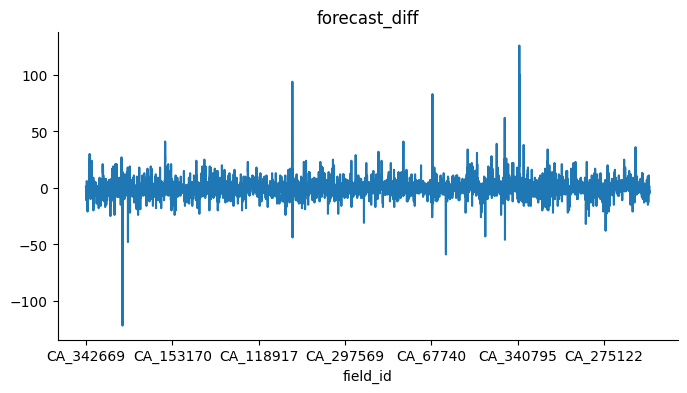

In [12]:
forecast_comparison_table['forecast_diff'].plot(kind='line', figsize=(8, 4), title='forecast_diff')
plt.gca().spines[['top', 'right']].set_visible(False)

## Metrics Comparison

In [13]:
# Do the daily metrics for each field.
daily_metrics = dt_daily.groupby(['field_id', 'crop']).apply(calculate_metrics)

daily_metrics

,,mae,rmse,corr,bias,skill_score
field_id,crop,,,,,
CA_100310,72,0.32,0.52,0.88,-0.07,0.77
CA_100588,47,0.32,0.51,0.82,0.15,0.64
CA_100873,215,0.41,0.67,0.88,-0.21,0.74
CA_101679,215,0.32,0.54,0.86,0.03,0.69
CA_101797,215,0.31,0.54,0.86,0.03,0.70
...,...,...,...,...,...,...
CA_98479,47,0.29,0.48,0.89,0.14,0.78
CA_98963,82,0.33,0.60,0.89,-0.12,0.74
CA_99201,61,0.43,0.76,0.87,-0.04,0.71


In [14]:
# And the weekly metrics
weekly_metrics = dt_weekly.groupby(['field_id', 'crop']).apply(calculate_metrics)

weekly_metrics

,,mae,rmse,corr,bias,skill_score
field_id,crop,,,,,
CA_100310,72,1.69,2.61,0.94,-0.49,0.86
CA_100588,47,1.97,3.09,0.86,1.06,0.70
CA_100873,215,2.22,3.63,0.93,-1.47,0.82
CA_101679,215,1.76,2.93,0.92,0.21,0.79
CA_101797,215,1.86,3.12,0.90,0.18,0.77
...,...,...,...,...,...,...
CA_98479,47,1.76,2.87,0.91,0.97,0.82
CA_98963,82,1.71,3.22,0.94,-0.85,0.83
CA_99201,61,2.40,4.11,0.93,-0.26,0.80


In [15]:
# And lastly, monthly metrics to compare
monthly_metrics = dt.groupby(['field_id', 'crop']).apply(calculate_metrics)

monthly_metrics

,,mae,rmse,corr,bias,skill_score
field_id,crop,,,,,
CA_100310,72,7.67,8.80,0.96,1.17,0.88
CA_100588,47,6.50,9.66,0.93,3.50,0.83
CA_100873,215,6.50,8.44,0.97,1.17,0.93
CA_101679,215,7.08,10.01,0.95,1.25,0.86
CA_101797,215,7.75,12.41,0.91,0.08,0.78
...,...,...,...,...,...,...
CA_98479,47,5.17,7.45,0.96,-1.17,0.92
CA_98963,82,7.75,12.11,0.96,-3.08,0.88
CA_99201,61,7.92,11.36,0.97,1.75,0.92


## Metrics Conclusion

In [16]:
daily_corr_mean = daily_metrics['corr'].mean()
weekly_corr_mean = weekly_metrics['corr'].mean()
monthly_corr_mean = monthly_metrics['corr'].mean()

print("Daily correlation mean:", daily_corr_mean)
print("Weekly correlation mean:", weekly_corr_mean)
print("Monthly correlation mean:", monthly_corr_mean)

Daily correlation mean: 0.8335477941176471
Weekly correlation mean: 0.8615992647058824
Monthly correlation mean: 0.8991727941176471


Interestingly enough, monthly data seems to be the most accurate. This *could* be due to the monthly forecast using data as far back as 1980. To see if this is the case, let's see the metrics on 2014+ based monthly data.

In [17]:
monthly_2014_metrics = dt_2014.groupby(['field_id', 'crop']).apply(calculate_metrics)

monthly_2014_corr_mean = monthly_2014_metrics['corr'].mean()

print("Monthly 2014 correlation mean:", monthly_2014_corr_mean)

Monthly 2014 correlation mean: 0.9107904411764706


In [36]:
# Export each of these metrics
daily_metrics.to_csv('daily_metrics.csv')
weekly_metrics.to_csv('weekly_metrics.csv')
monthly_metrics.to_csv('monthly_metrics.csv')
monthly_2014_metrics.to_csv('monthly_2014_metrics.csv')

Seems like that wasn't the case. Predictions based on 2014+ data has the highest correlation coefficient on average. There seems to be other factors at play.

## Variation Plotting

In [19]:
# Due to the amount of unique field IDs, for preview purposes, plot the et_diff variation of the first four fields
# sns.boxplot(x='time', y='et_diff', hue='field_id', data=dt_weekly.groupby('field_id'));

## Field analysis
The table as is isn't much helpful. Best to group the table by fields

In [57]:
dt_fields = dt[['field_id', 'et_actual', 'et_forecast', 'diff']].groupby(['field_id'])

## Crop analysis

Another useful table would be grouping by crops.

In [58]:
dt_crops = dt[['crop', 'et_actual', 'et_forecast', 'diff']].groupby(['crop'])


Creating a table for crop averages tells us the average ET for each type of crop.

Since a diff column was added in the beginning, the table also shows the average difference in ET forecasting to its actual.

In [59]:
dt_crop_average = dt_crops[['et_actual', 'et_forecast', 'diff']].mean()

print(dt_crop_average)

      et_actual  et_forecast      diff
crop                                  
3     87.728070    80.697368 -7.030702
36    66.673913    65.420290 -1.253623
47    59.725962    57.211939 -2.514022
61    50.250000    46.808974 -3.441026
66    83.083333    79.533333 -3.550000
67    81.320513    81.826923  0.506410
69    50.046948    49.397887 -0.649061
72    69.023438    69.299479  0.276042
75    86.319940    87.339286  1.019345
76    73.720238    80.119048  6.398810
78    71.824074    65.916667 -5.907407
82    78.750000    81.833333  3.083333
122   43.208333    47.333333  4.125000
141   54.000000    61.716667  7.716667
152   30.666667    33.583333  2.916667
176   67.120748    68.841837  1.721088
204   77.354167    76.833333 -0.520833
211   65.965278    68.152778  2.187500
215   75.384615    73.185897 -2.198718
220   82.380952    83.309524  0.928571
241   83.825758    82.852273 -0.973485


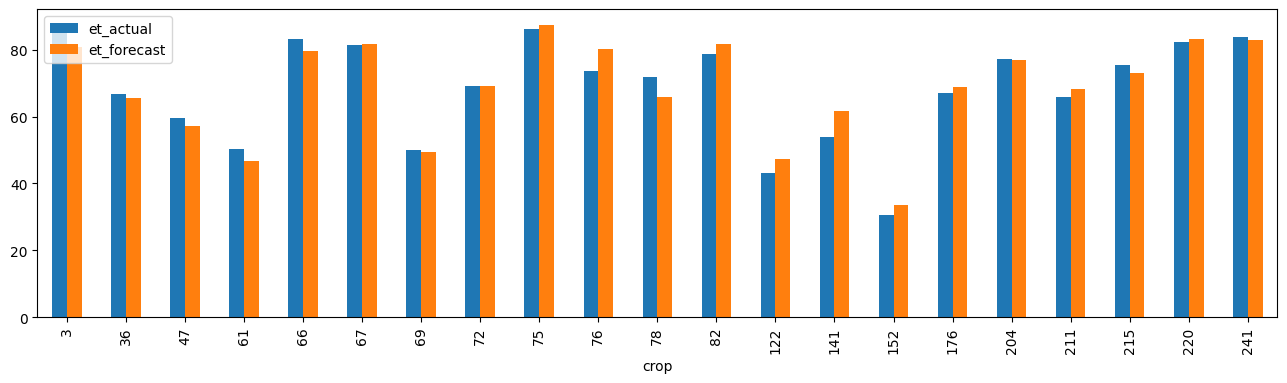

In [60]:
dt_crop_average[['et_actual', 'et_forecast']].plot.bar(figsize=(16, 4), legend="best");

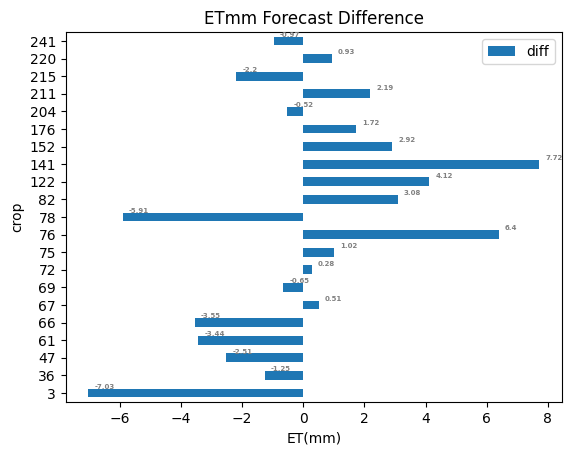

In [61]:
dtca_plot = dt_crop_average[['diff']].plot.barh(title="ETmm Forecast Difference", xlabel="ET(mm)");

for i in dtca_plot.patches:
    dtca_plot.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 5, fontweight ='bold',
             color ='grey')